In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from create_flop_data import FlopDataset
import torch
from modeling_utils import plot_latent_space, extract_z_samples
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from utils import flop_to_vector, flop_look_up, vec_to_flop

In [2]:
batch_size = 64
data = FlopDataset()
trainloader = DataLoader(data, batch_size=batch_size, shuffle=True)


In [3]:
class BaseVAE(nn.Module):
    def __init__(self, input_dim=51, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU()
        )
        
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_log_var = nn.Linear(64, latent_dim) 
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.LeakyReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=input_dim),
            nn.Sigmoid()
            )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar) 
        eps = torch.randn_like(std)
        return mu + eps * std 
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_log_var(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
        

In [20]:
def loss_function(x_recon, x, mu, log_var, beta=.5):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = recon_loss + beta * kl_divergence
    
    return loss, recon_loss, kl_divergence


In [21]:
model = BaseVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

In [22]:
loss_tracker = []
recon_loss_tracker = []
kl_div_tracker = []

for epoch in range(1,epochs+1):
    model.train() 
    tot_loss = 0
    tot_recon_loss = 0
    tot_kl_div = 0
    for flop_vec, flop, label_vec in trainloader:
        
        optimizer.zero_grad()
        x = flop_vec.to(torch.float32)
        x_recon, mu, log_var = model(x) 
    
        loss, recon_loss, kl_div = loss_function(x_recon, x, mu, log_var)
        tot_loss += loss.item()
        tot_recon_loss += recon_loss.item()
        tot_kl_div += kl_div.item()
        loss.backward()
        optimizer.step()
        
    avg_loss = tot_loss / len(trainloader)
    avg_recon_loss = tot_recon_loss / len(trainloader)
    avg_kl_div = tot_kl_div / len(trainloader)
    
    loss_tracker.append(avg_loss)
    recon_loss_tracker.append(avg_recon_loss)
    kl_div_tracker.append(avg_kl_div)

    if (epoch % 5) == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [5/100], Loss: 1037.2352
Epoch [10/100], Loss: 1036.6726
Epoch [15/100], Loss: 1036.4009
Epoch [20/100], Loss: 1036.2611
Epoch [25/100], Loss: 1036.1008
Epoch [30/100], Loss: 1035.9374
Epoch [35/100], Loss: 1035.9733
Epoch [40/100], Loss: 1035.8159
Epoch [45/100], Loss: 1035.8655
Epoch [50/100], Loss: 1035.8063
Epoch [55/100], Loss: 1035.7897
Epoch [60/100], Loss: 1035.7163
Epoch [65/100], Loss: 1035.7147
Epoch [70/100], Loss: 1035.7013
Epoch [75/100], Loss: 1035.6945
Epoch [80/100], Loss: 1035.6622
Epoch [85/100], Loss: 1035.6416
Epoch [90/100], Loss: 1035.5846
Epoch [95/100], Loss: 1035.6425
Epoch [100/100], Loss: 1035.5778


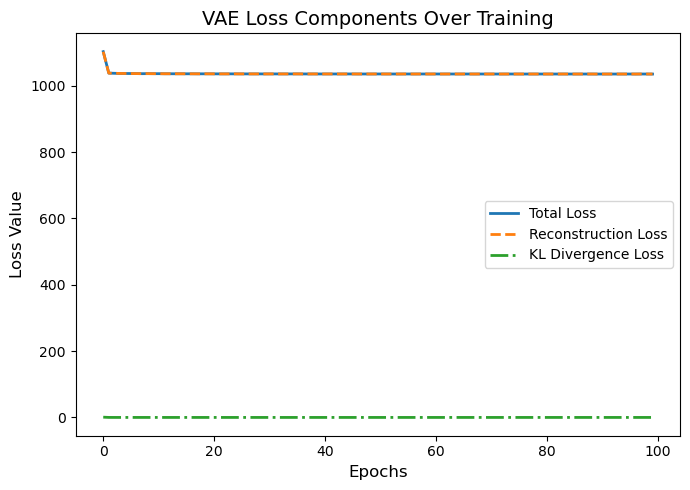

In [23]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=list(range(epochs)), y=loss_tracker, label="Total Loss", linestyle='-', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=recon_loss_tracker, label="Reconstruction Loss", linestyle='--', linewidth=2)
sns.lineplot(x=list(range(epochs)), y=kl_div_tracker, label="KL Divergence Loss", linestyle='-.', linewidth=2)

plt.title("VAE Loss Components Over Training", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)

plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()

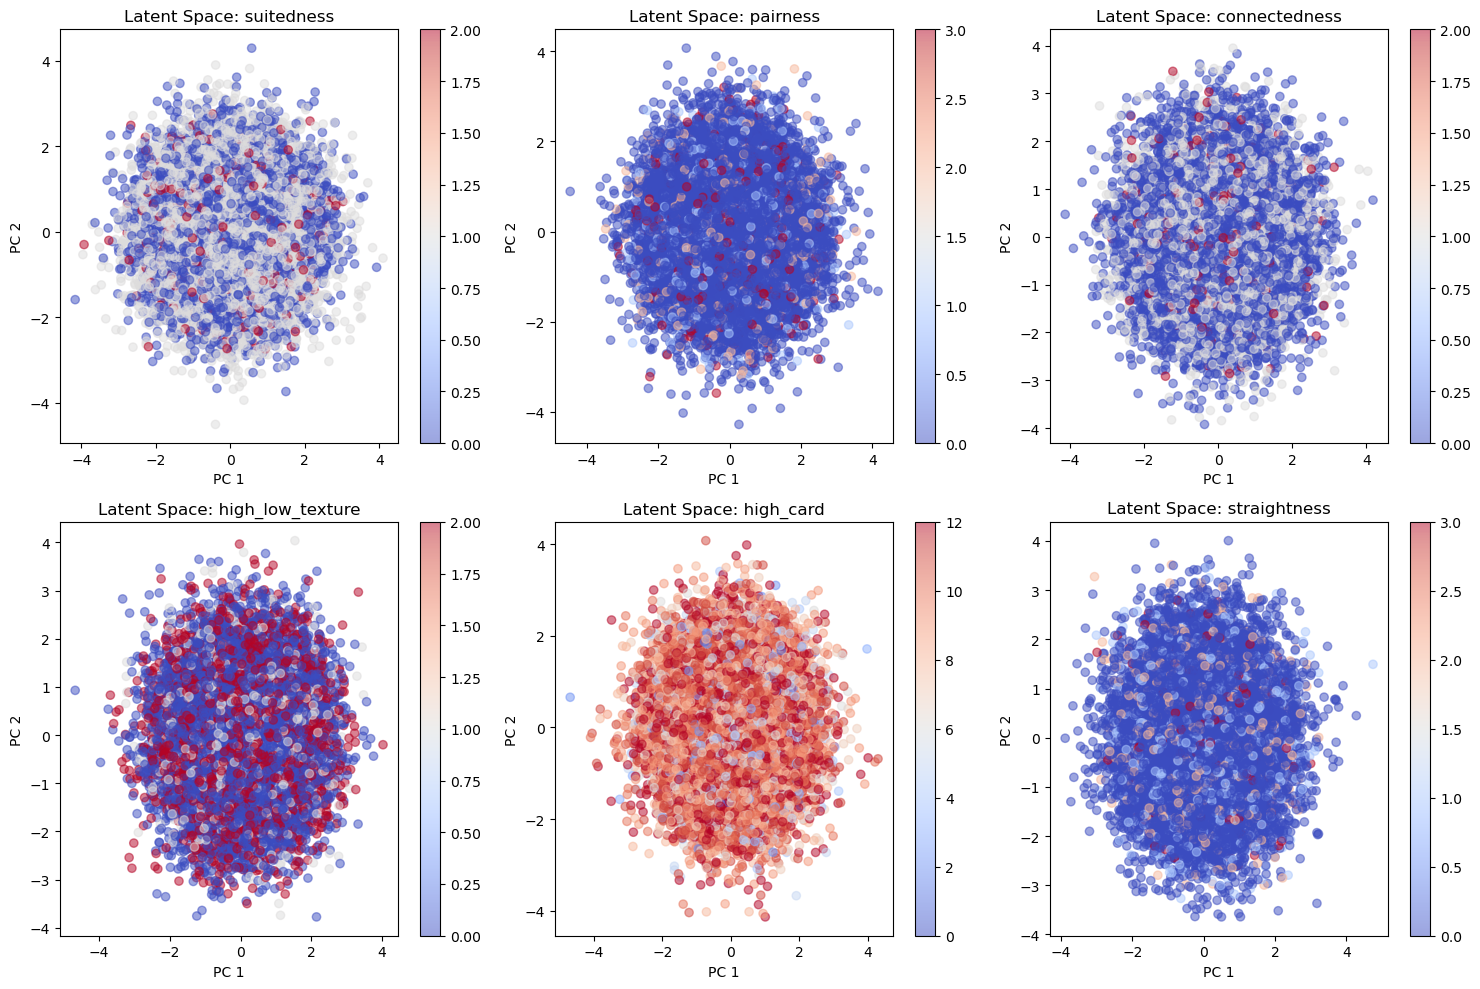

In [25]:
plot_latent_space(model, trainloader)